# BSDS500 Benchmark

The BSDS500 Image Segmentation dataset is a benchmark designed for evaluating Computer Vision algorithms and Deep Learning models in the task of Image Segmentation. Image segmentation methods generally fall into categories such as threshold-based, edge-based, region-growing, and deep learning approaches.

The Statistical Region Merging (SRM) algorithm, introduced by R. Nock and F. Nielsen in 2004, belongs to the region-growing category. While SRM is recognized for its speed and versatility, it has largely been overshadowed by advancements in deep learning, particularly in handling complex segmentation tasks like Semantic Segmentation, where modern, well-trained models excel. Traditional algorithms like SRM are now considered outdated in this context.

In [1]:
import subprocess
from pathlib import Path
import random
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Below are some utility functions that will be used for the benchmark

In [2]:
# Utility for creating a DataFrame where I will store the results
def create_df() -> pd.DataFrame:
    columns = {
        "implementation" : str,
        "q" : int,
        "max_regions" : int,
        "min_size" : float,
        "user" : int,
        "system" : int,
        "elapsed" : str,
        "CPU" : int,
        "Swaps" : int
    }
    return pd.DataFrame({col: pd.Series(dtype=typ) for col, typ in columns.items()})

In [3]:
# Utility for creating a DataFrame record to be appended to the Pandas DataFrame
def create_record(impl: str, q: int, max_reg: int ,min_size: float, user_time: float, sys_time: float,elapsed_time: str, cpu_percentage: int, swaps: int) -> dict:
    return {
        "implementation" : impl,
        "q" : q,
        "max_regions" : max_reg,
        "min_size" : min_size,
        "user" : user_time,
        "system" : sys_time,
        "elapsed" : elapsed_time,
        "CPU" : cpu_percentage,
        "Swaps" : swaps
    }

In [4]:
# Utility for parsing the information of interest from the input string
def get_task_time(input_str: str) -> str:
    if "user" in input_str:
        return input_str.split("u")[0]
    if "system" in input_str:
        return input_str.split("s")[0]
    if "elapsed" in input_str:
        return input_str.split("e")[0]
    if "CPU" in input_str:
        return input_str.split("%")[0]

In [5]:
# Utility for processing the output of the time prrogram and creating a new record to be appended on the DataFrame
def generate_record(impl: str, q: int, max_reg: int, min_size:float, time_output: str) -> dict:
    # Get the first output line of the time program
    interest_line = time_output.splitlines()[0]
    # Get the second line for the number of swaps
    swap_line = time_output.splitlines()[1]
    # Parse the line with the number of swaps appropriately
    swaps = swap_line.split()[2]
    swaps = swaps.split("s")[0]
    splt_str = interest_line.split()
    # Process the first line with user, system, elapsed time and CPU usage
    stats = list()
    for i in range(4):
        stats.append(get_task_time(splt_str[i]))
    # Append the result to the previously created DataFrame
    new_record = create_record(impl, q, max_reg, min_size, float(stats[0]), float(stats[1]), stats[2], int(stats[3]), int(swaps))

    return new_record

In [22]:
# The list of parameters on which the SRM will be 'grid-searched'
q_params = list(range(28,35))
max_reg_params = list(range(10,17))
min_size_params = np.linspace(0.001, 0.01, 5)
# Round the numbers to avoid numeric and program instability
min_size_params = np.round(min_size_params, 3)

In [7]:
# Path to the time command
time_command = Path("/usr/bin/time")

In [8]:
# Utility for getting random files from the Image directory, where the dataset lies
def get_random_images(directory: str, ammount: int) -> list:

    # Get a list of files in the directory (excluding directories)
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Select N random files, with N the ammount var
    random_files = random.sample(files, ammount)

    return random_files

In [9]:
# Benchmark execution helper function - Python
def py_benchmark_program(image: str, arg1: str, arg2: str, arg3: str) -> str:
    
    python_script = Path("../libsrm_py/srm.py")
    
    command = [str(time_command), "python3", str(python_script), str(image), arg1, arg2, arg3]

    try:
        # Run the command and capture output
        result = subprocess.run(
            command, 
            stdout=subprocess.PIPE,  # Captures standard output
            stderr=subprocess.PIPE,  # Captures standard error
            text=True,               # Decodes output to strings
            check=True               # Raises exception on failure
        )

        return result.stderr


    except subprocess.CalledProcessError as e:
        # Handle errors
        print(f"Error occurred: {e}")
        print(f"Output: {e.output}")
        print(f"Error: {e.stderr}")

In [10]:
# Benchmark execution helper function - C++
def cpp_benchmark_program(image: str, arg1: str, arg2: str, arg3: str) -> str:
    
    cpp_exe = Path("../libsrm_cpp/build/Executables/main_exec")
    
    command = [str(time_command), str(cpp_exe), str(image), arg1, arg2, arg3]

    try:
        # Run the command and capture output
        result = subprocess.run(
            command, 
            stdout=subprocess.PIPE,  # Captures standard output
            stderr=subprocess.PIPE,  # Captures standard error
            text=True,               # Decodes output to strings
            check=True               # Raises exception on failure
        )
        
        return result.stderr



    except subprocess.CalledProcessError as e:
        # Handle errors
        print(f"Error occurred: {e}")
        print(f"Output: {e.output}")
        print(f"Error: {e.stderr}")

In [45]:
# Benchmark execution helper function - Rust
def rust_benchmark_program(image: str, arg1: str, arg2: str, arg3: str) -> str:
    
    rust_proj = Path("../libsrm_rust/target/debug/libsrm_rust")
        
    command = [str(time_command), str(rust_proj), str(image), arg1, arg2, arg3]

    try:
        # Run the command and capture output
        result = subprocess.run(
            command, 
            stdout=subprocess.PIPE,  # Captures standard output
            stderr=subprocess.PIPE,  # Captures standard error
            text=True,               # Decodes output to strings
            check=True               # Raises exception on failure
        )
        
        return result.stderr



    except subprocess.CalledProcessError as e:
        # Handle errors
        print(f"Error occurred: {e}")
        print(f"Output: {e.output}")
        print(f"Error: {e.stderr}")

---

## Beware

The cells below presume that you have already ***installed*** all of the ***required dependencies*** as specified in the ***GitHub README.md***, this means building the ***C++*** project and compiling the project with the appropriate ***Makefile***, created by the ***CMake*** tool, and performing a clean ***cargo build*** before running the ***Rust*** example

---

# Running the Benchmark

---

In [12]:
# Get 5 random images
bsd_images = get_random_images("./images", 5)

In [13]:
# Creat the specific dataframe based on the implementation
py_df = create_df()
cpp_df = create_df()
rust_df = create_df()

In [14]:
# Keep track of the total ammount of runs to perform
tot_runs = len(bsd_images) * len(q_params) * len(max_reg_params) * len(min_size_params)

In [15]:
# Running the Python implementation's Grid Search
PYTHON_ITERATION = 0

for bsd_image in bsd_images:
    bsd_image = "./images/" + bsd_image
    for q in q_params:
        for max_reg in max_reg_params:
            for min_size in min_size_params:
                try:
                    # 1) run the program on the speific parameter set
                    result_str = py_benchmark_program(bsd_image, str(q), str(max_reg), str(min_size))
                    # 2) create a record from the obtained information
                    new_record = generate_record("python", q, max_reg, min_size, result_str)
                    # 3) append the newly found record to the reference DataFrame
                    py_df = pd.concat([py_df, pd.DataFrame([new_record])], ignore_index=True)
                    print(f"({PYTHON_ITERATION} / {tot_runs}) Processed [{bsd_image}] - [{q}, {max_reg}, {min_size}]")
                    PYTHON_ITERATION += 1
                except Exception as e:
                    print(f"{e}")

(0 / 1225) Processed [./images/seg_img_346.jpg] - [28, 8, 0.001]
(1 / 1225) Processed [./images/seg_img_346.jpg] - [28, 8, 0.0032500000000000003]
(2 / 1225) Processed [./images/seg_img_346.jpg] - [28, 8, 0.0055000000000000005]
(3 / 1225) Processed [./images/seg_img_346.jpg] - [28, 8, 0.007750000000000001]
(4 / 1225) Processed [./images/seg_img_346.jpg] - [28, 8, 0.01]
(5 / 1225) Processed [./images/seg_img_346.jpg] - [28, 9, 0.001]
(6 / 1225) Processed [./images/seg_img_346.jpg] - [28, 9, 0.0032500000000000003]
(7 / 1225) Processed [./images/seg_img_346.jpg] - [28, 9, 0.0055000000000000005]
(8 / 1225) Processed [./images/seg_img_346.jpg] - [28, 9, 0.007750000000000001]
(9 / 1225) Processed [./images/seg_img_346.jpg] - [28, 9, 0.01]
(10 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.001]
(11 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.0032500000000000003]
(12 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.0055000000000000005]
(13 / 1225) Processed [./

(108 / 1225) Processed [./images/seg_img_346.jpg] - [31, 8, 0.007750000000000001]
(109 / 1225) Processed [./images/seg_img_346.jpg] - [31, 8, 0.01]
(110 / 1225) Processed [./images/seg_img_346.jpg] - [31, 9, 0.001]
(111 / 1225) Processed [./images/seg_img_346.jpg] - [31, 9, 0.0032500000000000003]
(112 / 1225) Processed [./images/seg_img_346.jpg] - [31, 9, 0.0055000000000000005]
(113 / 1225) Processed [./images/seg_img_346.jpg] - [31, 9, 0.007750000000000001]
(114 / 1225) Processed [./images/seg_img_346.jpg] - [31, 9, 0.01]
(115 / 1225) Processed [./images/seg_img_346.jpg] - [31, 10, 0.001]
(116 / 1225) Processed [./images/seg_img_346.jpg] - [31, 10, 0.0032500000000000003]
(117 / 1225) Processed [./images/seg_img_346.jpg] - [31, 10, 0.0055000000000000005]
(118 / 1225) Processed [./images/seg_img_346.jpg] - [31, 10, 0.007750000000000001]
(119 / 1225) Processed [./images/seg_img_346.jpg] - [31, 10, 0.01]
(120 / 1225) Processed [./images/seg_img_346.jpg] - [31, 11, 0.001]
(121 / 1225) Proc

(215 / 1225) Processed [./images/seg_img_346.jpg] - [34, 9, 0.001]
(216 / 1225) Processed [./images/seg_img_346.jpg] - [34, 9, 0.0032500000000000003]
(217 / 1225) Processed [./images/seg_img_346.jpg] - [34, 9, 0.0055000000000000005]
(218 / 1225) Processed [./images/seg_img_346.jpg] - [34, 9, 0.007750000000000001]
(219 / 1225) Processed [./images/seg_img_346.jpg] - [34, 9, 0.01]
(220 / 1225) Processed [./images/seg_img_346.jpg] - [34, 10, 0.001]
(221 / 1225) Processed [./images/seg_img_346.jpg] - [34, 10, 0.0032500000000000003]
(222 / 1225) Processed [./images/seg_img_346.jpg] - [34, 10, 0.0055000000000000005]
(223 / 1225) Processed [./images/seg_img_346.jpg] - [34, 10, 0.007750000000000001]
(224 / 1225) Processed [./images/seg_img_346.jpg] - [34, 10, 0.01]
(225 / 1225) Processed [./images/seg_img_346.jpg] - [34, 11, 0.001]
(226 / 1225) Processed [./images/seg_img_346.jpg] - [34, 11, 0.0032500000000000003]
(227 / 1225) Processed [./images/seg_img_346.jpg] - [34, 11, 0.005500000000000000

(322 / 1225) Processed [./images/seg_img_420.jpg] - [30, 9, 0.0055000000000000005]
(323 / 1225) Processed [./images/seg_img_420.jpg] - [30, 9, 0.007750000000000001]
(324 / 1225) Processed [./images/seg_img_420.jpg] - [30, 9, 0.01]
(325 / 1225) Processed [./images/seg_img_420.jpg] - [30, 10, 0.001]
(326 / 1225) Processed [./images/seg_img_420.jpg] - [30, 10, 0.0032500000000000003]
(327 / 1225) Processed [./images/seg_img_420.jpg] - [30, 10, 0.0055000000000000005]
(328 / 1225) Processed [./images/seg_img_420.jpg] - [30, 10, 0.007750000000000001]
(329 / 1225) Processed [./images/seg_img_420.jpg] - [30, 10, 0.01]
(330 / 1225) Processed [./images/seg_img_420.jpg] - [30, 11, 0.001]
(331 / 1225) Processed [./images/seg_img_420.jpg] - [30, 11, 0.0032500000000000003]
(332 / 1225) Processed [./images/seg_img_420.jpg] - [30, 11, 0.0055000000000000005]
(333 / 1225) Processed [./images/seg_img_420.jpg] - [30, 11, 0.007750000000000001]
(334 / 1225) Processed [./images/seg_img_420.jpg] - [30, 11, 0.0

(429 / 1225) Processed [./images/seg_img_420.jpg] - [33, 9, 0.01]
(430 / 1225) Processed [./images/seg_img_420.jpg] - [33, 10, 0.001]
(431 / 1225) Processed [./images/seg_img_420.jpg] - [33, 10, 0.0032500000000000003]
(432 / 1225) Processed [./images/seg_img_420.jpg] - [33, 10, 0.0055000000000000005]
(433 / 1225) Processed [./images/seg_img_420.jpg] - [33, 10, 0.007750000000000001]
(434 / 1225) Processed [./images/seg_img_420.jpg] - [33, 10, 0.01]
(435 / 1225) Processed [./images/seg_img_420.jpg] - [33, 11, 0.001]
(436 / 1225) Processed [./images/seg_img_420.jpg] - [33, 11, 0.0032500000000000003]
(437 / 1225) Processed [./images/seg_img_420.jpg] - [33, 11, 0.0055000000000000005]
(438 / 1225) Processed [./images/seg_img_420.jpg] - [33, 11, 0.007750000000000001]
(439 / 1225) Processed [./images/seg_img_420.jpg] - [33, 11, 0.01]
(440 / 1225) Processed [./images/seg_img_420.jpg] - [33, 12, 0.001]
(441 / 1225) Processed [./images/seg_img_420.jpg] - [33, 12, 0.0032500000000000003]
(442 / 122

(536 / 1225) Processed [./images/seg_img_324.jpg] - [29, 10, 0.0032500000000000003]
(537 / 1225) Processed [./images/seg_img_324.jpg] - [29, 10, 0.0055000000000000005]
(538 / 1225) Processed [./images/seg_img_324.jpg] - [29, 10, 0.007750000000000001]
(539 / 1225) Processed [./images/seg_img_324.jpg] - [29, 10, 0.01]
(540 / 1225) Processed [./images/seg_img_324.jpg] - [29, 11, 0.001]
(541 / 1225) Processed [./images/seg_img_324.jpg] - [29, 11, 0.0032500000000000003]
(542 / 1225) Processed [./images/seg_img_324.jpg] - [29, 11, 0.0055000000000000005]
(543 / 1225) Processed [./images/seg_img_324.jpg] - [29, 11, 0.007750000000000001]
(544 / 1225) Processed [./images/seg_img_324.jpg] - [29, 11, 0.01]
(545 / 1225) Processed [./images/seg_img_324.jpg] - [29, 12, 0.001]
(546 / 1225) Processed [./images/seg_img_324.jpg] - [29, 12, 0.0032500000000000003]
(547 / 1225) Processed [./images/seg_img_324.jpg] - [29, 12, 0.0055000000000000005]
(548 / 1225) Processed [./images/seg_img_324.jpg] - [29, 12,

(643 / 1225) Processed [./images/seg_img_324.jpg] - [32, 10, 0.007750000000000001]
(644 / 1225) Processed [./images/seg_img_324.jpg] - [32, 10, 0.01]
(645 / 1225) Processed [./images/seg_img_324.jpg] - [32, 11, 0.001]
(646 / 1225) Processed [./images/seg_img_324.jpg] - [32, 11, 0.0032500000000000003]
(647 / 1225) Processed [./images/seg_img_324.jpg] - [32, 11, 0.0055000000000000005]
(648 / 1225) Processed [./images/seg_img_324.jpg] - [32, 11, 0.007750000000000001]
(649 / 1225) Processed [./images/seg_img_324.jpg] - [32, 11, 0.01]
(650 / 1225) Processed [./images/seg_img_324.jpg] - [32, 12, 0.001]
(651 / 1225) Processed [./images/seg_img_324.jpg] - [32, 12, 0.0032500000000000003]
(652 / 1225) Processed [./images/seg_img_324.jpg] - [32, 12, 0.0055000000000000005]
(653 / 1225) Processed [./images/seg_img_324.jpg] - [32, 12, 0.007750000000000001]
(654 / 1225) Processed [./images/seg_img_324.jpg] - [32, 12, 0.01]
(655 / 1225) Processed [./images/seg_img_324.jpg] - [32, 13, 0.001]
(656 / 122

(750 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.001]
(751 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.0032500000000000003]
(752 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.0055000000000000005]
(753 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.007750000000000001]
(754 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.01]
(755 / 1225) Processed [./images/seg_img_417.jpg] - [28, 12, 0.001]
(756 / 1225) Processed [./images/seg_img_417.jpg] - [28, 12, 0.0032500000000000003]
(757 / 1225) Processed [./images/seg_img_417.jpg] - [28, 12, 0.0055000000000000005]
(758 / 1225) Processed [./images/seg_img_417.jpg] - [28, 12, 0.007750000000000001]
(759 / 1225) Processed [./images/seg_img_417.jpg] - [28, 12, 0.01]
(760 / 1225) Processed [./images/seg_img_417.jpg] - [28, 13, 0.001]
(761 / 1225) Processed [./images/seg_img_417.jpg] - [28, 13, 0.0032500000000000003]
(762 / 1225) Processed [./images/seg_img_417.jpg] - [28, 13, 0.0055000000000

(857 / 1225) Processed [./images/seg_img_417.jpg] - [31, 11, 0.0055000000000000005]
(858 / 1225) Processed [./images/seg_img_417.jpg] - [31, 11, 0.007750000000000001]
(859 / 1225) Processed [./images/seg_img_417.jpg] - [31, 11, 0.01]
(860 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.001]
(861 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.0032500000000000003]
(862 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.0055000000000000005]
(863 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.007750000000000001]
(864 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.01]
(865 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.001]
(866 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.0032500000000000003]
(867 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.0055000000000000005]
(868 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.007750000000000001]
(869 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 

(964 / 1225) Processed [./images/seg_img_417.jpg] - [34, 11, 0.01]
(965 / 1225) Processed [./images/seg_img_417.jpg] - [34, 12, 0.001]
(966 / 1225) Processed [./images/seg_img_417.jpg] - [34, 12, 0.0032500000000000003]
(967 / 1225) Processed [./images/seg_img_417.jpg] - [34, 12, 0.0055000000000000005]
(968 / 1225) Processed [./images/seg_img_417.jpg] - [34, 12, 0.007750000000000001]
(969 / 1225) Processed [./images/seg_img_417.jpg] - [34, 12, 0.01]
(970 / 1225) Processed [./images/seg_img_417.jpg] - [34, 13, 0.001]
(971 / 1225) Processed [./images/seg_img_417.jpg] - [34, 13, 0.0032500000000000003]
(972 / 1225) Processed [./images/seg_img_417.jpg] - [34, 13, 0.0055000000000000005]
(973 / 1225) Processed [./images/seg_img_417.jpg] - [34, 13, 0.007750000000000001]
(974 / 1225) Processed [./images/seg_img_417.jpg] - [34, 13, 0.01]
(975 / 1225) Processed [./images/seg_img_417.jpg] - [34, 14, 0.001]
(976 / 1225) Processed [./images/seg_img_417.jpg] - [34, 14, 0.0032500000000000003]
(977 / 12

(1070 / 1225) Processed [./images/seg_img_452.jpg] - [30, 12, 0.001]
(1071 / 1225) Processed [./images/seg_img_452.jpg] - [30, 12, 0.0032500000000000003]
(1072 / 1225) Processed [./images/seg_img_452.jpg] - [30, 12, 0.0055000000000000005]
(1073 / 1225) Processed [./images/seg_img_452.jpg] - [30, 12, 0.007750000000000001]
(1074 / 1225) Processed [./images/seg_img_452.jpg] - [30, 12, 0.01]
(1075 / 1225) Processed [./images/seg_img_452.jpg] - [30, 13, 0.001]
(1076 / 1225) Processed [./images/seg_img_452.jpg] - [30, 13, 0.0032500000000000003]
(1077 / 1225) Processed [./images/seg_img_452.jpg] - [30, 13, 0.0055000000000000005]
(1078 / 1225) Processed [./images/seg_img_452.jpg] - [30, 13, 0.007750000000000001]
(1079 / 1225) Processed [./images/seg_img_452.jpg] - [30, 13, 0.01]
(1080 / 1225) Processed [./images/seg_img_452.jpg] - [30, 14, 0.001]
(1081 / 1225) Processed [./images/seg_img_452.jpg] - [30, 14, 0.0032500000000000003]
(1082 / 1225) Processed [./images/seg_img_452.jpg] - [30, 14, 0.

(1176 / 1225) Processed [./images/seg_img_452.jpg] - [33, 12, 0.0032500000000000003]
(1177 / 1225) Processed [./images/seg_img_452.jpg] - [33, 12, 0.0055000000000000005]
(1178 / 1225) Processed [./images/seg_img_452.jpg] - [33, 12, 0.007750000000000001]
(1179 / 1225) Processed [./images/seg_img_452.jpg] - [33, 12, 0.01]
(1180 / 1225) Processed [./images/seg_img_452.jpg] - [33, 13, 0.001]
(1181 / 1225) Processed [./images/seg_img_452.jpg] - [33, 13, 0.0032500000000000003]
(1182 / 1225) Processed [./images/seg_img_452.jpg] - [33, 13, 0.0055000000000000005]
(1183 / 1225) Processed [./images/seg_img_452.jpg] - [33, 13, 0.007750000000000001]
(1184 / 1225) Processed [./images/seg_img_452.jpg] - [33, 13, 0.01]
(1185 / 1225) Processed [./images/seg_img_452.jpg] - [33, 14, 0.001]
(1186 / 1225) Processed [./images/seg_img_452.jpg] - [33, 14, 0.0032500000000000003]
(1187 / 1225) Processed [./images/seg_img_452.jpg] - [33, 14, 0.0055000000000000005]
(1188 / 1225) Processed [./images/seg_img_452.jp

In [16]:
# Save the obtained DataFrame into a .CSV file
py_df.to_csv("python_impl_benchmark.csv", index=False)
print("Exported the Python benchmark DataFrame to .CSV")

Exported the Python benchmark DataFrame to .CSV


In [32]:
# Running the C++ implementation's Grid Search
CPP_ITERATION = 0

for bsd_image in bsd_images:
    bsd_image = "./images/" + bsd_image
    for q in q_params:
        for max_reg in max_reg_params:
            for min_size in min_size_params:
                try:
                    # 1) run the program on the speific parameter set
                    result_str = cpp_benchmark_program(bsd_image, str(q), str(max_reg), str(min_size))
                    # 2) create a record from the obtained information
                    new_record = generate_record("cpp", q, max_reg, min_size, result_str)
                    # 3) append the newly found record to the reference DataFrame
                    cpp_df = pd.concat([cpp_df, pd.DataFrame([new_record])], ignore_index=True)
                    print(f"({CPP_ITERATION} / {tot_runs}) Processed [{bsd_image}] - [{q}, {max_reg}, {min_size}]")
                    CPP_ITERATION += 1
                except Exception as e:
                    print(f"{e}")

(0 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.001]
(1 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.003]
(2 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.006]
(3 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.008]
(4 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.01]
(5 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.001]
(6 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.003]
(7 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.006]
(8 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.008]
(9 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.01]
(10 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.001]
(11 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.003]
(12 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.006]
(13 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.008]
(14 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.01]
(15 / 12

(123 / 1225) Processed [./images/seg_img_346.jpg] - [31, 13, 0.008]
(124 / 1225) Processed [./images/seg_img_346.jpg] - [31, 13, 0.01]
(125 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.001]
(126 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.003]
(127 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.006]
(128 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.008]
(129 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.01]
(130 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.001]
(131 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.003]
(132 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.006]
(133 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.008]
(134 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.01]
(135 / 1225) Processed [./images/seg_img_346.jpg] - [31, 16, 0.001]
(136 / 1225) Processed [./images/seg_img_346.jpg] - [31, 16, 0.003]
(137 / 1225) Processed [./images/seg_img_346.jpg] -

(244 / 1225) Processed [./images/seg_img_346.jpg] - [34, 16, 0.01]
(245 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.001]
(246 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.003]
(247 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.006]
(248 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.008]
(249 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.01]
(250 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.001]
(251 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.003]
(252 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.006]
(253 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.008]
(254 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.01]
(255 / 1225) Processed [./images/seg_img_420.jpg] - [28, 12, 0.001]
(256 / 1225) Processed [./images/seg_img_420.jpg] - [28, 12, 0.003]
(257 / 1225) Processed [./images/seg_img_420.jpg] - [28, 12, 0.006]
(258 / 1225) Processed [./images/seg_img_420.jpg] -

(365 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.001]
(366 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.003]
(367 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.006]
(368 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.008]
(369 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.01]
(370 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.001]
(371 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.003]
(372 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.006]
(373 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.008]
(374 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.01]
(375 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.001]
(376 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.003]
(377 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.006]
(378 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.008]
(379 / 1225) Processed [./images/seg_img_420.jpg] 

(486 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.003]
(487 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.006]
(488 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.008]
(489 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.01]
(490 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.001]
(491 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.003]
(492 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.006]
(493 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.008]
(494 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.01]
(495 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.001]
(496 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.003]
(497 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.006]
(498 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.008]
(499 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.01]
(500 / 1225) Processed [./images/seg_img_324.jpg] -

(607 / 1225) Processed [./images/seg_img_324.jpg] - [31, 12, 0.006]
(608 / 1225) Processed [./images/seg_img_324.jpg] - [31, 12, 0.008]
(609 / 1225) Processed [./images/seg_img_324.jpg] - [31, 12, 0.01]
(610 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.001]
(611 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.003]
(612 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.006]
(613 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.008]
(614 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.01]
(615 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.001]
(616 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.003]
(617 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.006]
(618 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.008]
(619 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.01]
(620 / 1225) Processed [./images/seg_img_324.jpg] - [31, 15, 0.001]
(621 / 1225) Processed [./images/seg_img_324.jpg] -

(728 / 1225) Processed [./images/seg_img_324.jpg] - [34, 15, 0.008]
(729 / 1225) Processed [./images/seg_img_324.jpg] - [34, 15, 0.01]
(730 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.001]
(731 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.003]
(732 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.006]
(733 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.008]
(734 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.01]
(735 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.001]
(736 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.003]
(737 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.006]
(738 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.008]
(739 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.01]
(740 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.001]
(741 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.003]
(742 / 1225) Processed [./images/seg_img_417.jpg] -

(849 / 1225) Processed [./images/seg_img_417.jpg] - [31, 11, 0.01]
(850 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.001]
(851 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.003]
(852 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.006]
(853 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.008]
(854 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.01]
(855 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.001]
(856 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.003]
(857 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.006]
(858 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.008]
(859 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.01]
(860 / 1225) Processed [./images/seg_img_417.jpg] - [31, 14, 0.001]
(861 / 1225) Processed [./images/seg_img_417.jpg] - [31, 14, 0.003]
(862 / 1225) Processed [./images/seg_img_417.jpg] - [31, 14, 0.006]
(863 / 1225) Processed [./images/seg_img_417.jpg] -

(970 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.001]
(971 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.003]
(972 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.006]
(973 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.008]
(974 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.01]
(975 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.001]
(976 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.003]
(977 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.006]
(978 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.008]
(979 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.01]
(980 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.001]
(981 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.003]
(982 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.006]
(983 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.008]
(984 / 1225) Processed [./images/seg_img_452.jpg] 

(1090 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.001]
(1091 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.003]
(1092 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.006]
(1093 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.008]
(1094 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.01]
(1095 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.001]
(1096 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.003]
(1097 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.006]
(1098 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.008]
(1099 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.01]
(1100 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.001]
(1101 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.003]
(1102 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.006]
(1103 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.008]
(1104 / 1225) Processed [./images/se

(1210 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.001]
(1211 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.003]
(1212 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.006]
(1213 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.008]
(1214 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.01]
(1215 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.001]
(1216 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.003]
(1217 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.006]
(1218 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.008]
(1219 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.01]
(1220 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.001]
(1221 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.003]
(1222 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.006]
(1223 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.008]
(1224 / 1225) Processed [./images/se

In [33]:
cpp_df.to_csv("cpp_impl_benchmark.csv", index=False)
print("Exported the C++ Benchmark DataFrame to .CSV")

Exported the C++ Benchmark DataFrame to .CSV


In [47]:
# Running the Rust implementation's Grid Search
RUST_ITERATION = 0

for bsd_image in bsd_images:
    bsd_image = "./images/" + bsd_image
    for q in q_params:
        for max_reg in max_reg_params:
            for min_size in min_size_params:
                try:
                    # 1) run the program on the speific parameter set
                    result_str = rust_benchmark_program(bsd_image, str(q), str(max_reg), str(min_size))
                    # 2) create a record from the obtained information
                    new_record = generate_record("rust", q, max_reg, min_size, result_str)
                    # 3) append the newly found record to the reference DataFrame
                    rust_df = pd.concat([rust_df, pd.DataFrame([new_record])], ignore_index=True)
                    print(f"({RUST_ITERATION} / {tot_runs}) Processed [{bsd_image}] - [{q}, {max_reg}, {min_size}]")
                    RUST_ITERATION += 1
                except Exception as e:
                    print(f"{e}")

(0 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.001]
(1 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.003]
(2 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.006]
(3 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.008]
(4 / 1225) Processed [./images/seg_img_346.jpg] - [28, 10, 0.01]
(5 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.001]
(6 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.003]
(7 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.006]
(8 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.008]
(9 / 1225) Processed [./images/seg_img_346.jpg] - [28, 11, 0.01]
(10 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.001]
(11 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.003]
(12 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.006]
(13 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.008]
(14 / 1225) Processed [./images/seg_img_346.jpg] - [28, 12, 0.01]
(15 / 12

(123 / 1225) Processed [./images/seg_img_346.jpg] - [31, 13, 0.008]
(124 / 1225) Processed [./images/seg_img_346.jpg] - [31, 13, 0.01]
(125 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.001]
(126 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.003]
(127 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.006]
(128 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.008]
(129 / 1225) Processed [./images/seg_img_346.jpg] - [31, 14, 0.01]
(130 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.001]
(131 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.003]
(132 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.006]
(133 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.008]
(134 / 1225) Processed [./images/seg_img_346.jpg] - [31, 15, 0.01]
(135 / 1225) Processed [./images/seg_img_346.jpg] - [31, 16, 0.001]
(136 / 1225) Processed [./images/seg_img_346.jpg] - [31, 16, 0.003]
(137 / 1225) Processed [./images/seg_img_346.jpg] -

(244 / 1225) Processed [./images/seg_img_346.jpg] - [34, 16, 0.01]
(245 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.001]
(246 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.003]
(247 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.006]
(248 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.008]
(249 / 1225) Processed [./images/seg_img_420.jpg] - [28, 10, 0.01]
(250 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.001]
(251 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.003]
(252 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.006]
(253 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.008]
(254 / 1225) Processed [./images/seg_img_420.jpg] - [28, 11, 0.01]
(255 / 1225) Processed [./images/seg_img_420.jpg] - [28, 12, 0.001]
(256 / 1225) Processed [./images/seg_img_420.jpg] - [28, 12, 0.003]
(257 / 1225) Processed [./images/seg_img_420.jpg] - [28, 12, 0.006]
(258 / 1225) Processed [./images/seg_img_420.jpg] -

(365 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.001]
(366 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.003]
(367 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.006]
(368 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.008]
(369 / 1225) Processed [./images/seg_img_420.jpg] - [31, 13, 0.01]
(370 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.001]
(371 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.003]
(372 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.006]
(373 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.008]
(374 / 1225) Processed [./images/seg_img_420.jpg] - [31, 14, 0.01]
(375 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.001]
(376 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.003]
(377 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.006]
(378 / 1225) Processed [./images/seg_img_420.jpg] - [31, 15, 0.008]
(379 / 1225) Processed [./images/seg_img_420.jpg] 

(486 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.003]
(487 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.006]
(488 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.008]
(489 / 1225) Processed [./images/seg_img_420.jpg] - [34, 16, 0.01]
(490 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.001]
(491 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.003]
(492 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.006]
(493 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.008]
(494 / 1225) Processed [./images/seg_img_324.jpg] - [28, 10, 0.01]
(495 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.001]
(496 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.003]
(497 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.006]
(498 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.008]
(499 / 1225) Processed [./images/seg_img_324.jpg] - [28, 11, 0.01]
(500 / 1225) Processed [./images/seg_img_324.jpg] -

(607 / 1225) Processed [./images/seg_img_324.jpg] - [31, 12, 0.006]
(608 / 1225) Processed [./images/seg_img_324.jpg] - [31, 12, 0.008]
(609 / 1225) Processed [./images/seg_img_324.jpg] - [31, 12, 0.01]
(610 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.001]
(611 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.003]
(612 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.006]
(613 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.008]
(614 / 1225) Processed [./images/seg_img_324.jpg] - [31, 13, 0.01]
(615 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.001]
(616 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.003]
(617 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.006]
(618 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.008]
(619 / 1225) Processed [./images/seg_img_324.jpg] - [31, 14, 0.01]
(620 / 1225) Processed [./images/seg_img_324.jpg] - [31, 15, 0.001]
(621 / 1225) Processed [./images/seg_img_324.jpg] -

(728 / 1225) Processed [./images/seg_img_324.jpg] - [34, 15, 0.008]
(729 / 1225) Processed [./images/seg_img_324.jpg] - [34, 15, 0.01]
(730 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.001]
(731 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.003]
(732 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.006]
(733 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.008]
(734 / 1225) Processed [./images/seg_img_324.jpg] - [34, 16, 0.01]
(735 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.001]
(736 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.003]
(737 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.006]
(738 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.008]
(739 / 1225) Processed [./images/seg_img_417.jpg] - [28, 10, 0.01]
(740 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.001]
(741 / 1225) Processed [./images/seg_img_417.jpg] - [28, 11, 0.003]
(742 / 1225) Processed [./images/seg_img_417.jpg] -

(849 / 1225) Processed [./images/seg_img_417.jpg] - [31, 11, 0.01]
(850 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.001]
(851 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.003]
(852 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.006]
(853 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.008]
(854 / 1225) Processed [./images/seg_img_417.jpg] - [31, 12, 0.01]
(855 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.001]
(856 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.003]
(857 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.006]
(858 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.008]
(859 / 1225) Processed [./images/seg_img_417.jpg] - [31, 13, 0.01]
(860 / 1225) Processed [./images/seg_img_417.jpg] - [31, 14, 0.001]
(861 / 1225) Processed [./images/seg_img_417.jpg] - [31, 14, 0.003]
(862 / 1225) Processed [./images/seg_img_417.jpg] - [31, 14, 0.006]
(863 / 1225) Processed [./images/seg_img_417.jpg] -

(970 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.001]
(971 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.003]
(972 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.006]
(973 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.008]
(974 / 1225) Processed [./images/seg_img_417.jpg] - [34, 15, 0.01]
(975 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.001]
(976 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.003]
(977 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.006]
(978 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.008]
(979 / 1225) Processed [./images/seg_img_417.jpg] - [34, 16, 0.01]
(980 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.001]
(981 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.003]
(982 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.006]
(983 / 1225) Processed [./images/seg_img_452.jpg] - [28, 10, 0.008]
(984 / 1225) Processed [./images/seg_img_452.jpg] 

(1090 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.001]
(1091 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.003]
(1092 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.006]
(1093 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.008]
(1094 / 1225) Processed [./images/seg_img_452.jpg] - [31, 11, 0.01]
(1095 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.001]
(1096 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.003]
(1097 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.006]
(1098 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.008]
(1099 / 1225) Processed [./images/seg_img_452.jpg] - [31, 12, 0.01]
(1100 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.001]
(1101 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.003]
(1102 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.006]
(1103 / 1225) Processed [./images/seg_img_452.jpg] - [31, 13, 0.008]
(1104 / 1225) Processed [./images/se

(1210 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.001]
(1211 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.003]
(1212 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.006]
(1213 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.008]
(1214 / 1225) Processed [./images/seg_img_452.jpg] - [34, 14, 0.01]
(1215 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.001]
(1216 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.003]
(1217 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.006]
(1218 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.008]
(1219 / 1225) Processed [./images/seg_img_452.jpg] - [34, 15, 0.01]
(1220 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.001]
(1221 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.003]
(1222 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.006]
(1223 / 1225) Processed [./images/seg_img_452.jpg] - [34, 16, 0.008]
(1224 / 1225) Processed [./images/se

In [48]:
rust_df.to_csv("rust_impl_benchmark.csv", index=False)
print("Exported the Rust Benchmark Dataframe to .CSV")

Exported the Rust Benchmark Dataframe to .CSV


--- 

## Interpreting the Results

---

In [49]:
# Peek at the Python implementation DataFrame
py_df

,implementation,q,max_regions,min_size,user,system,elapsed,CPU,Swaps
0,python,28,8,0.00100,4.34,1.19,0:05.80,95,0
1,python,28,8,0.00325,4.30,1.01,0:04.31,123,0
2,python,28,8,0.00550,4.30,0.89,0:04.16,124,0
3,python,28,8,0.00775,4.31,0.88,0:04.08,127,0
4,python,28,8,0.01000,4.18,0.94,0:04.09,125,0
...,...,...,...,...,...,...,...,...,...
1220,python,34,14,0.00100,4.99,0.94,0:04.88,121,0
1221,python,34,14,0.00325,4.78,0.83,0:04.56,123,0
1222,python,34,14,0.00550,4.45,0.88,0:04.26,125,0
1223,python,34,14,0.00775,4.07,0.95,0:03.89,129,0


In [50]:
# Peek at the C++ implementaion DataFrame
cpp_df

,implementation,q,max_regions,min_size,user,system,elapsed,CPU,Swaps
0,cpp,28,10,0.001,3.48,0.74,0:03.38,124,0
1,cpp,28,10,0.003,3.54,0.73,0:03.16,135,0
2,cpp,28,10,0.006,3.82,0.80,0:03.58,129,0
3,cpp,28,10,0.008,3.50,0.77,0:03.16,135,0
4,cpp,28,10,0.010,3.71,0.74,0:03.30,135,0
...,...,...,...,...,...,...,...,...,...
1220,cpp,34,16,0.001,3.48,0.74,0:03.11,135,0
1221,cpp,34,16,0.003,3.32,0.85,0:03.07,136,0
1222,cpp,34,16,0.006,3.51,0.71,0:03.11,135,0
1223,cpp,34,16,0.008,3.47,0.73,0:03.12,134,0


In [51]:
# Peek at the Rust implementation DataFrame
rust_df

,implementation,q,max_regions,min_size,user,system,elapsed,CPU,Swaps
0,rust,28,10,0.001,1.18,0.85,0:01.18,172,0
1,rust,28,10,0.003,1.05,0.90,0:00.99,197,0
2,rust,28,10,0.006,1.16,0.91,0:00.98,210,0
3,rust,28,10,0.008,0.91,0.91,0:00.81,223,0
4,rust,28,10,0.010,0.80,0.99,0:00.69,256,0
...,...,...,...,...,...,...,...,...,...
1230,rust,34,16,0.001,0.86,0.88,0:00.69,251,0
1231,rust,34,16,0.003,0.89,0.86,0:00.67,262,0
1232,rust,34,16,0.006,0.80,0.96,0:00.70,253,0
1233,rust,34,16,0.008,0.80,0.95,0:00.66,267,0


---

# Some Statistics Regarding the Benchmark

---

In [87]:
py_df[["user", "system", "CPU"]].describe()

,user,system,CPU
count,1225.000000,1225.000000,1225.000000
mean,4.297771,0.879592,126.535510
std,0.171721,0.067521,2.342542
min,3.890000,0.670000,95.000000
25%,4.190000,0.830000,125.000000
50%,4.270000,0.880000,127.000000
75%,4.370000,0.920000,128.000000
max,5.280000,1.190000,132.000000


In [88]:
cpp_df[["user", "system", "CPU"]].describe()

,user,system,CPU
count,1225.000000,1225.000000,1225.000000
mean,3.442645,0.795331,134.727347
std,0.104178,0.056307,2.199401
min,3.260000,0.590000,118.000000
25%,3.390000,0.760000,134.000000
50%,3.440000,0.790000,135.000000
75%,3.480000,0.830000,136.000000
max,5.110000,1.010000,143.000000


In [89]:
rust_df[["user", "system", "CPU"]].describe()

,user,system,CPU
count,1235.000000,1235.000000,1235.000000
mean,0.823352,0.921555,267.327935
std,0.065155,0.060010,14.655531
min,0.580000,0.740000,172.000000
25%,0.780000,0.880000,257.000000
50%,0.820000,0.920000,268.000000
75%,0.860000,0.960000,277.000000
max,1.180000,1.240000,307.000000


---

Based on a preliminary description of the different dataframes, it is easy to see that on ***average***,
the ***C++*** implementation has the lowest ***system*** consumption, but that should come as no surprise considering that syscalls are all translated into the OS-native version, which is ***C***

<br>

However ***Rust*** has by far the lowest ***user*** consumption, this comes as a slight surprise considering that
normally ***C-Based*** implementations are to data the fastest implementations available, however with ***Rust's*** zero cost abstractions and binary execution, the speed in the userspace is well justified

<br>

It comes however as a shocking surprise that, ***on average***, the highest overall ***CPU*** consumption is caused by the ***Rust*** implementation and the ***lowest*** by the ***Python*** implementation 

---

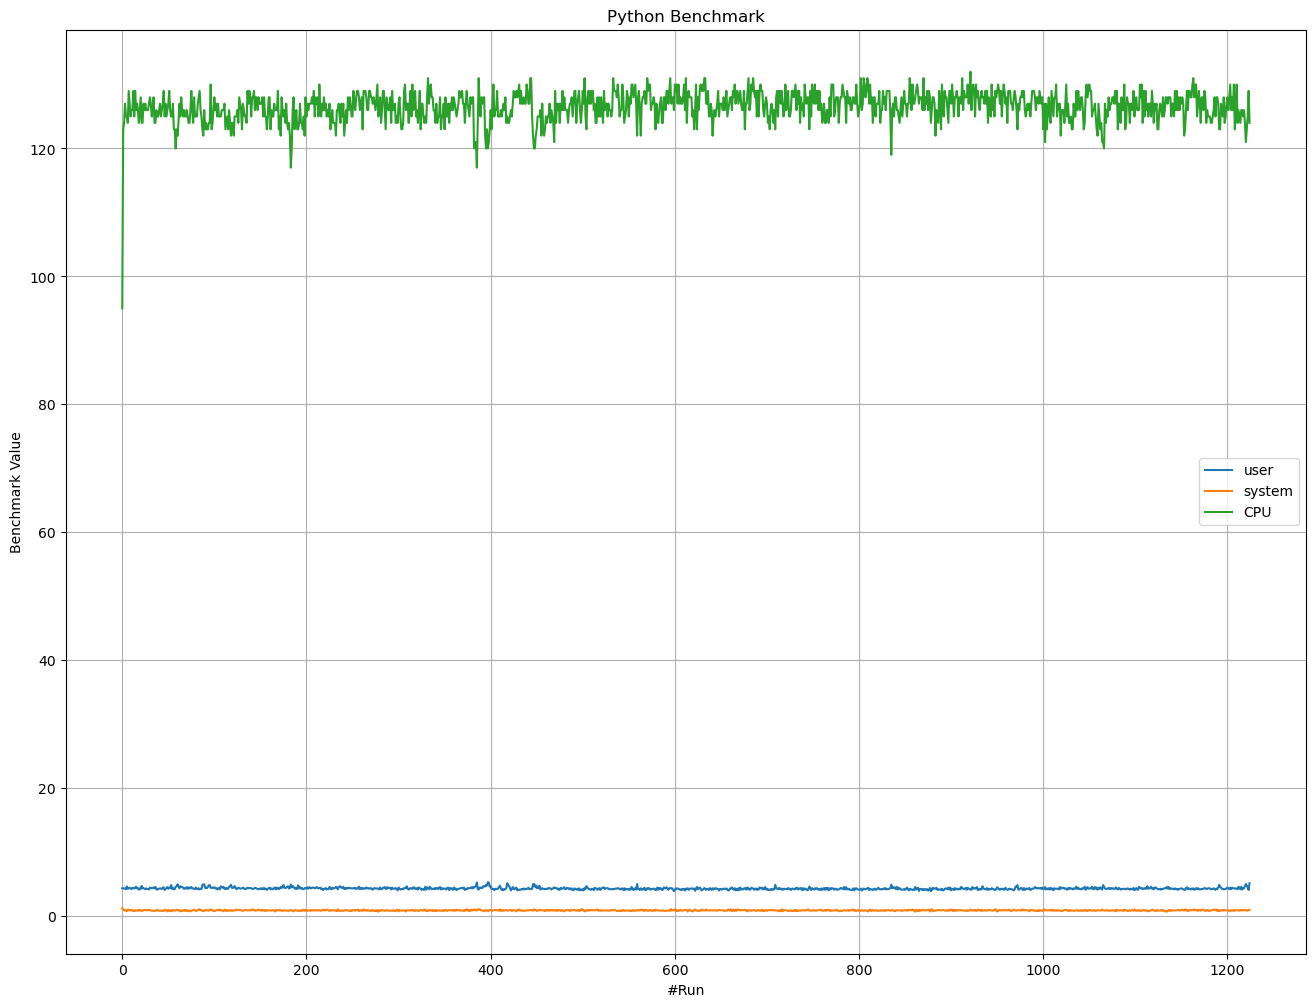

In [66]:
ax = py_df[["user", "system", "elapsed", "CPU"]].plot(figsize=(16,12))
ax.set_title("Python Benchmark")
ax.set_xlabel("#Run")
ax.set_ylabel("Benchmark Value")
ax.grid(True)

plt.show()

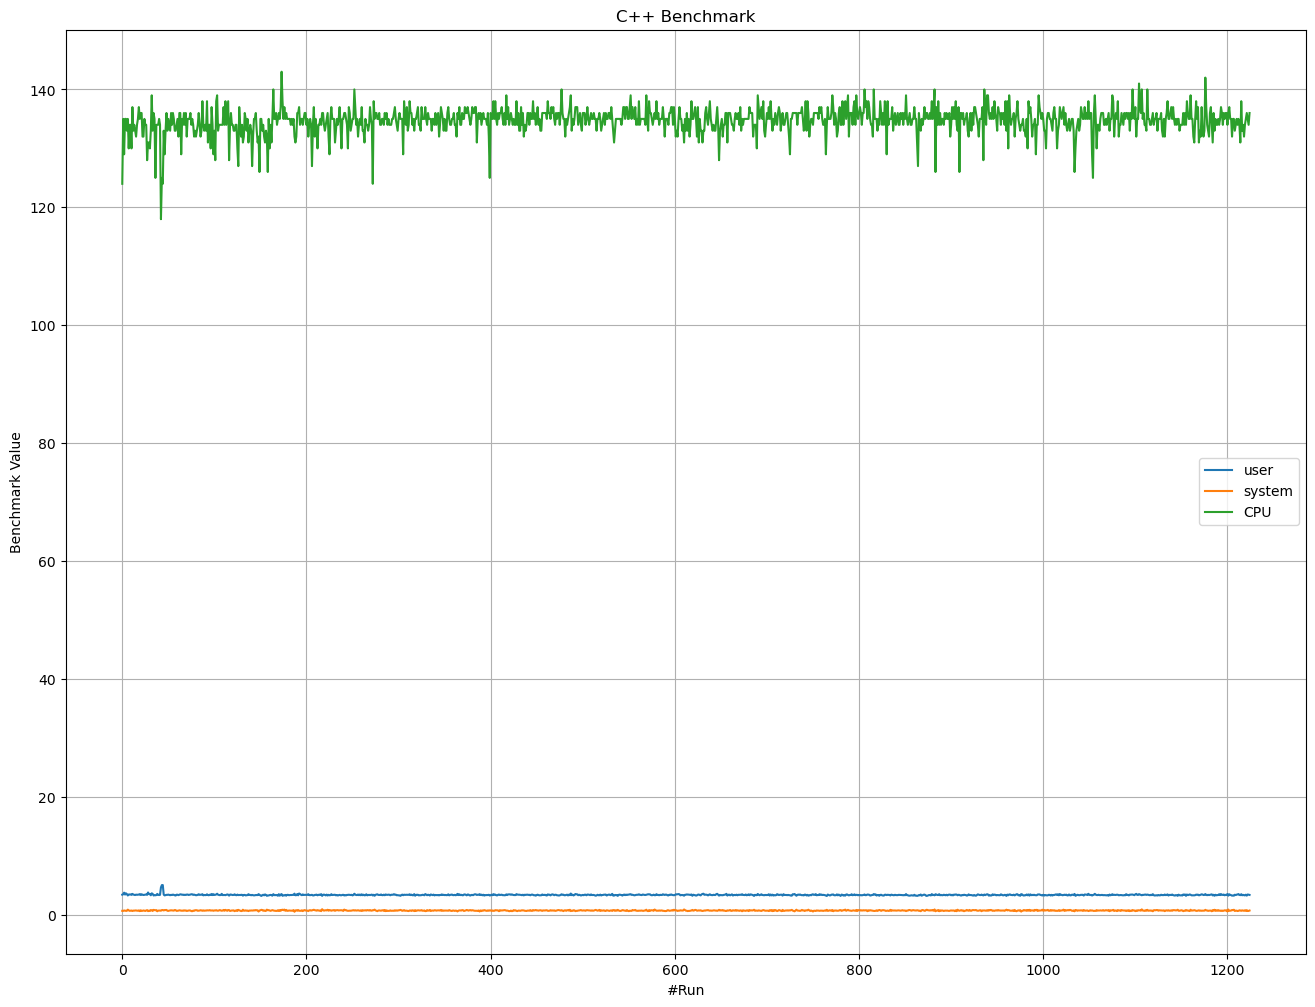

In [65]:
ax = cpp_df[["user", "system", "elapsed", "CPU"]].plot(figsize=(16,12))
ax.set_title("C++ Benchmark")
ax.set_xlabel("#Run")
ax.set_ylabel("Benchmark Value")
ax.grid(True)

plt.show()

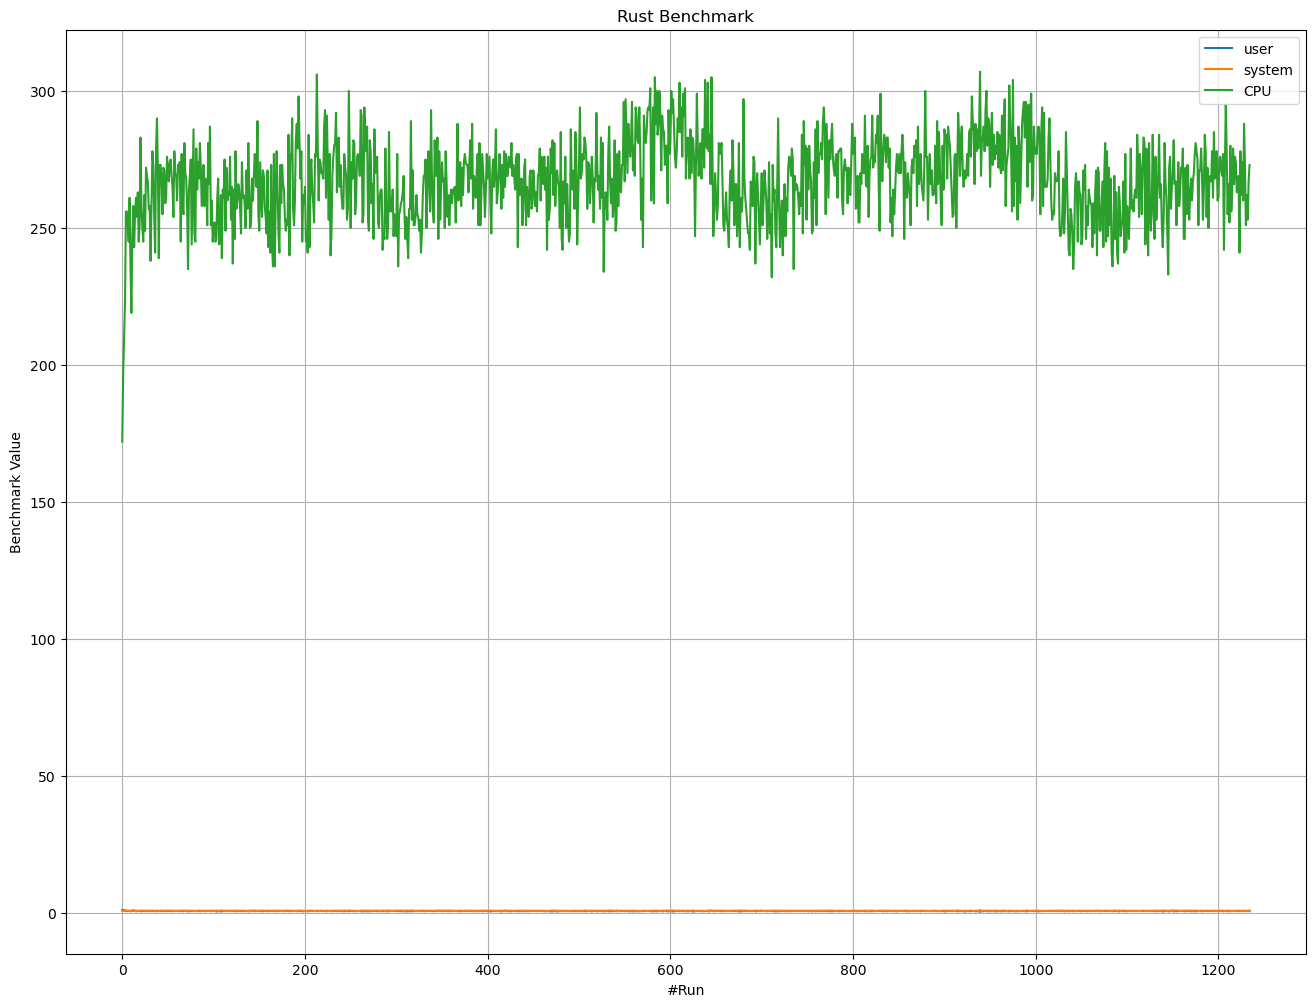

In [64]:
ax = rust_df[["user", "system", "elapsed", "CPU"]].plot(figsize=(16,12))
ax.set_title("Rust Benchmark")
ax.set_xlabel("#Run")
ax.set_ylabel("Benchmark Value")
ax.grid(True)

plt.show()

---

In [84]:
# Boxplot helper function
def get_boxplot(df_col: str, title_name: str) -> None:
    target_col = [py_df[df_col], cpp_df[df_col], rust_df[df_col]]
    plt.figure(figsize=(16,12))
    plt.title(f"{title_name} time boxplots")
    plt.boxplot(target_col, labels=["Python", "C++", "Rust"])
    plt.grid(True)
    plt.show() 

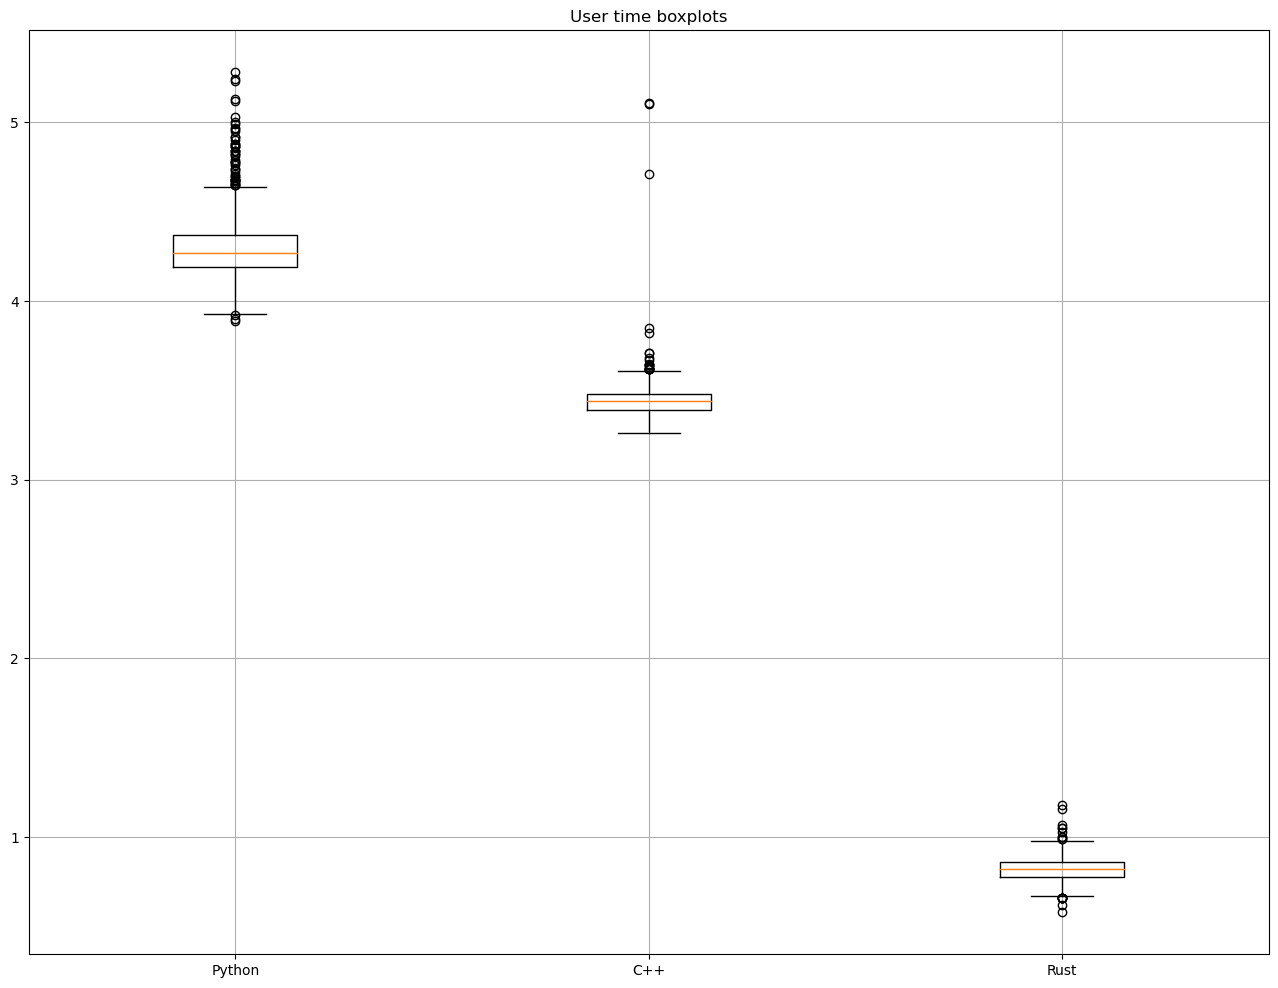

In [85]:
# Check Usertime differences
get_boxplot("user", "User")

---

From the ***boxplot*** above, it is easy to notice how the ***Rust*** implementation has a more contained distribution over ***user*** time, whereas ***Python*** has the most ***right-skewed*** distribution, despite having a more ***contained*** interquartile distance

---

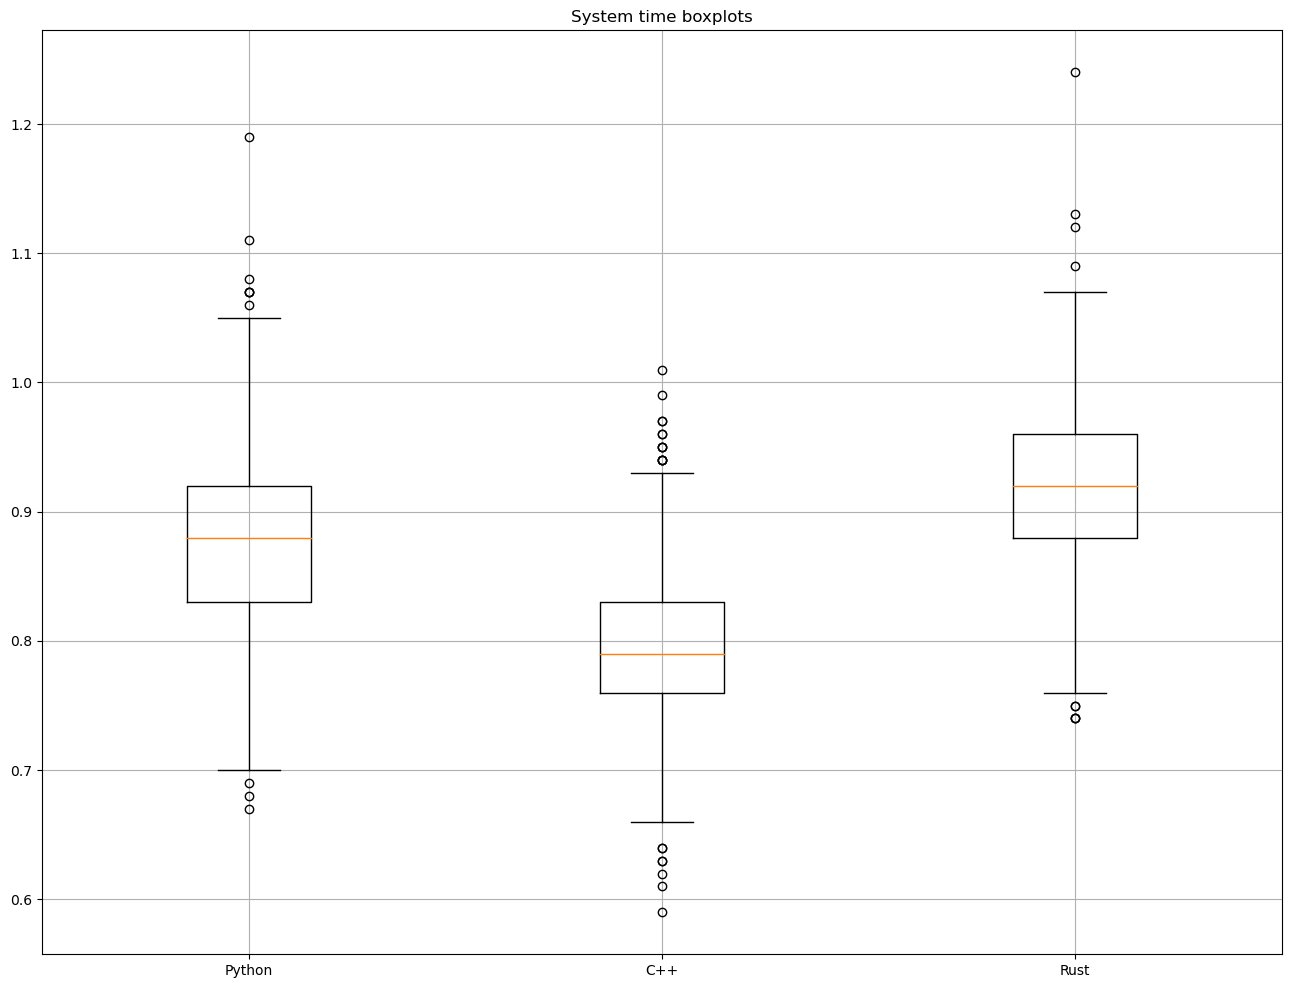

In [90]:
get_boxplot("system", "System")

---

The ***system*** boxplot as seen above shows a more consistent balance between the different implementations, with the ***Rust*** implementation being the most ***right-skewed*** implementation of them all

<br>

Despite being the most stable implementation, the ***C++*** implementation has the most outliers, despite them being 'stable' compared to the other implementations

---

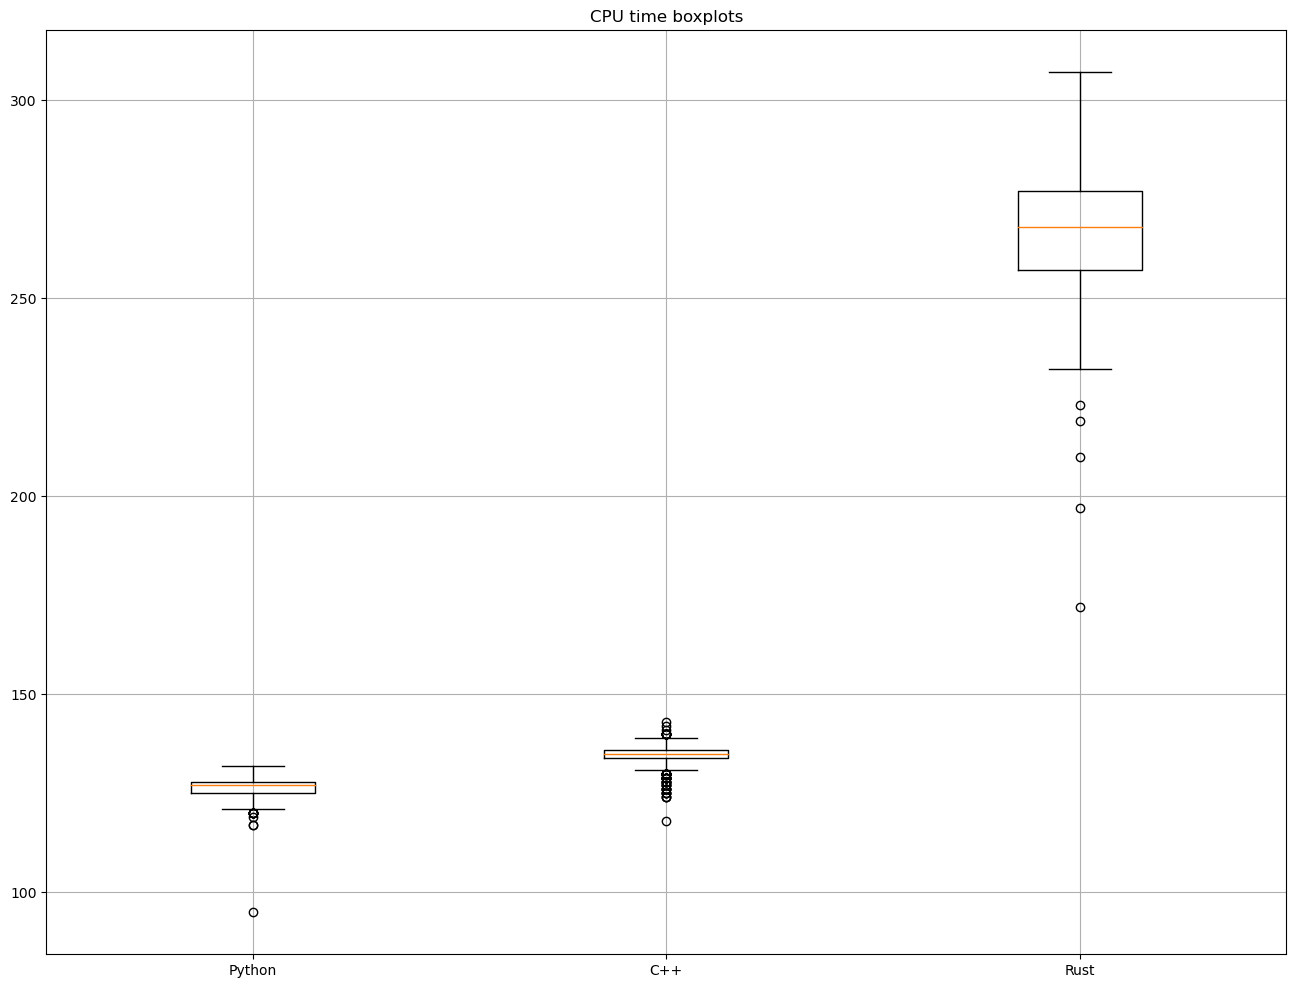

In [91]:
get_boxplot("CPU", "CPU")

---

With great surprise, the final boxplot shows confirms the initial observation, from the dataframe itself, where the lowest overall total ***CPU*** consumption is given by the ***Python*** implementation, with a however ***very stable*** ***C++*** implementation and very ***unstable*** ***Rust*** one


<br>

A final note shows that the newly plotted distributions are now ***left-skewed***

---

# Conclusions

---

Based on the collected data, when speed is of the ***top priority***, then the ***Rust*** implementation is definitely the most suitable solution when it comes to the ***Statistical Region Merging*** algorithm

<br>

However if low resource consumpion is the prioirty, in a potentially ***resource-limited*** environment, then surprisingly, the ***Python*** implementation is the most efficient, without performing ***extreme*** and ***hardware-specific*** optimizations, such as ***program-profiling*** to find potential bottlenecks and re-writing those portions of code in the target machine's ***assembly*** language

---

#### Credits

- Andrew R. Darnall, Computer Science Graduate Student at the University of Catania

---